# Imports

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats
import feature_compliation as pre_process

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Loading Data & Data Transformation

In [2]:
pre_process.feature_compliation()

Compliation completed


In [3]:
derivation_cohort = pd.read_csv("data/Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("data/External_validation_dataset.csv")
public_dataset = pd.read_csv("data/public_dataset.csv")

In [4]:
derivation_cohort = derivation_cohort.drop(['PR'], axis=1)
external_validation_cohort = external_validation_cohort.drop(['PR'], axis=1)


public_dataset = public_dataset.drop(['jt_anterior', 'jt_lateral', 'gender'], axis=1)
public_dataset = public_dataset.rename(columns={"age": "Age", "hr": "HR", 'q_dur': 'qdur_aVF',
                                                'ramp_avl': 'ramp_aVL', 'ramp_iii': 'ramp_III', 'ramp_v4': 'ramp_V4',
                                                'st80_avf': 'st80_aVF', 'st80_avl': 'st80_aVL', 'st80_i': 'st80_I',
                                                'st80_iii': 'st80_III', 'st80_v1': 'st80_V1', 'st80_v2': 'st80_V2', 
                                                'st80_v3': 'st80_V3', 'st80_v4': 'st80_V4', 'st80_v5': 'st80_V5',
                                                'st80_v6': 'st80_V6', 'tamp_avf': 'tamp_aVF', 'tamp_avl': 'tamp_aVL', 
                                                'tamp_avr': 'tamp_aVR', 'tamp_i': 'tamp_I', 'tamp_ii': 'tamp_II',
                                                'tamp_iii': 'tamp_III', 'tamp_v1': 'tamp_V1', 'tamp_v2': 'tamp_V2', 
                                                'tamp_v3': 'tamp_V3', 'tamp_v4': 'tamp_V4', 'tamp_v5': 'tamp_V5',
                                                'tamp_v6': 'tamp_V6', 'tpte': 'TpTe', 
                                                'vat_ii': 'vat_II', 'vat_iii': 'vat_III', 'vat_v2': 'vat_V2',
                                                'vat_v4': 'vat_V4'})

In [5]:
# derivation_cohort = derivation_cohort[['st80_III', 'st80_aVL', 'tamp_aVL', 'STT_PCAratio', 'st80_V2', 'TpTe', 'st80_aVF', 'tamp_III',
#                                        'st80_I', 'pcaTamp', 'st80_V6', 'fpTaxis', 'st80_V1', 'fpTinfl1Axis', 'PCA2', 'TampInfl1', 'antConcaveAmp',
#                                        'TCRT', 'T_PCAratio', 'st80_V4', 'HR', 'tamp_V4', 'st80_V3', 'Outcome_Occlusion_MI']]

# external_validation_cohort = external_validation_cohort[['st80_III', 'st80_aVL', 'tamp_aVL', 'STT_PCAratio', 'st80_V2', 'TpTe', 'st80_aVF', 'tamp_III',
#                                        'st80_I', 'pcaTamp', 'st80_V6', 'fpTaxis', 'st80_V1', 'fpTinfl1Axis', 'PCA2', 'TampInfl1', 'antConcaveAmp',
#                                        'TCRT', 'T_PCAratio', 'st80_V4', 'HR', 'tamp_V4', 'st80_V3', 'Outcome_Occlusion_MI']]

# public_dataset = public_dataset[['st80_III', 'st80_aVL', 'tamp_aVL', 'STT_PCAratio', 'st80_V2', 'TpTe', 'st80_aVF', 'tamp_III',
#                                        'st80_I', 'pcaTamp', 'st80_V6', 'fpTaxis', 'st80_V1', 'fpTinfl1Axis', 'PCA2', 'TampInfl1', 'antConcaveAmp',
#                                        'TCRT', 'T_PCAratio', 'st80_V4', 'HR', 'tamp_V4', 'st80_V3', 'mi']]

# Model Initialization

## Train, Test, Validation Split

In [6]:
y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

# y_val = external_validation_cohort['Outcome_Occlusion_MI']
# X_val = external_validation_cohort.drop('Outcome_Occlusion_MI', axis=1)

y_val = public_dataset['mi']
X_val = public_dataset.drop('mi', axis=1)

for el in X_train.columns:
    # fill NA with mode
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_test = np.ravel(np.array(y_test.values))

# temp fix
y_val = y_val.fillna(1)
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

## Random Forest Initialization

In [7]:
clf = RandomForestClassifier(class_weight='balanced', criterion='entropy', n_jobs=-1, random_state=42, 
                             max_features='sqrt', n_estimators=40, min_samples_split=0.01, min_samples_leaf=0.005,
                             min_impurity_decrease=1e-2, bootstrap=True, ccp_alpha=1e-2, max_samples=0.75, oob_score=True)

clf = CalibratedClassifierCV(clf, cv=5, method="isotonic")

## Helper Functions

In [8]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'RF (AUC = %0.2f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1] * 100, decimals = 2)
    y_pred = np.where(OMI_score < 5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score >= 20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return (pd.DataFrame(data = results, index=['Count (N)']))

In [10]:
def plot_precision_recall(y_train, pred_probas_train):
    precision, recall, _ = precision_recall_curve(y_train, pred_probas_train)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()

In [11]:
def plot_confusion_matrix(test, prediction):
    cm = confusion_matrix(test, prediction, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

In [12]:
def plot_Shapley(clf, df_test, cols, set_name, nf): #nf = number of features
    # Load JS visualization code to notebook
    shap.initjs()
    
    # Shapley explainability
    plt.figure()
    df = pd.DataFrame(data=df_test, columns=(cols))
    
    shap_values_list = []
    for calibrated_classifier in clf.calibrated_classifiers_:
        explainer = shap.TreeExplainer(calibrated_classifier.estimator)
        shap_values = explainer.shap_values(df)
        shap_values_list.append(shap_values)
    shap_values = np.array(shap_values_list).sum(axis=0) / len(shap_values_list)
    
    shap.summary_plot(shap_values[1], features=df, feature_names=np.array(cols), sort=True, show=False, max_display=nf, color_bar=False, plot_type='dot', plot_size=(5.00, 10.00))
    plt.title('Shapley values of the top '+str(nf)+'/'+str(len(cols))+' features for OMI prediction (derivation cohort)', fontweight="bold")
    plt.show()

# Model Performance

## Training

In [13]:
clf.fit(X_train, y_train)
pred_probas_train = clf.predict_proba(X_train)
risk_groups_train = results(pred_probas_train)

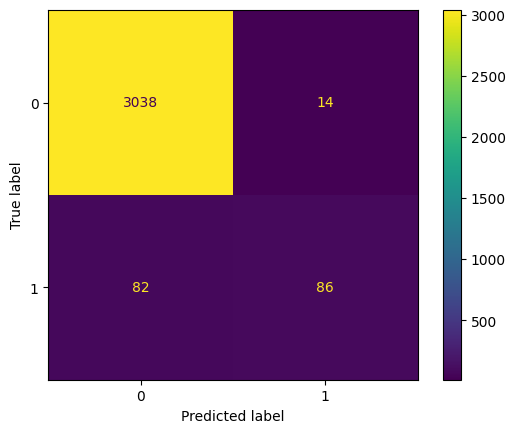

In [14]:
plot_confusion_matrix(y_train, clf.predict(X_train))

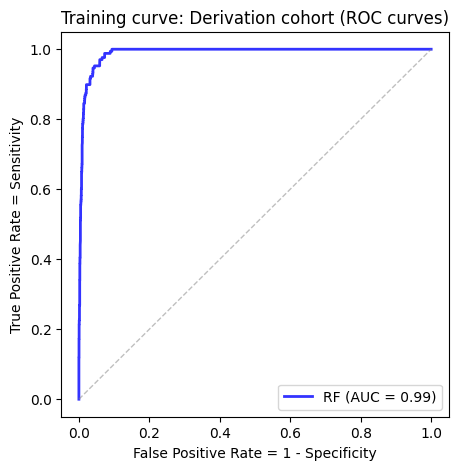

In [15]:
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

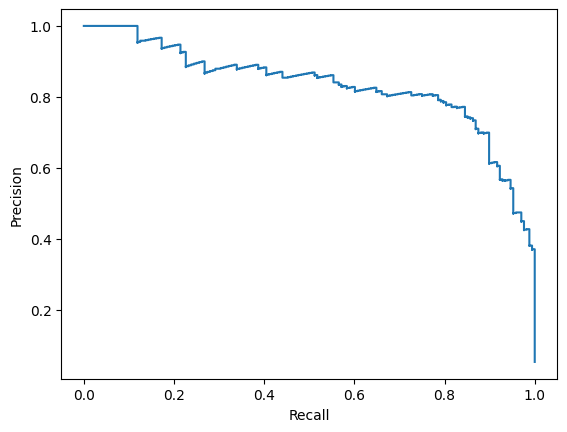

In [16]:
# Compute precision & recall
precision_train = average_precision_score(y_train, pred_probas_train[:,1])

plot_precision_recall(y_train, pred_probas_train[:,1])

In [17]:
print("Precision: {:.2f}".format(round(precision_train, 2)))

Precision: 0.83


In [18]:
# Kolmogorov– Smirnov goodness of fit
ks_train = stats.kstest(y_train, pred_probas_train[:,1])
# Gini purity index

In [19]:
risk_groups_train.head()

,Low risk,Intermediate risk,High risk
Count (N),2451,557,212


## Testing

In [20]:
pred_probas_test = clf.predict_proba(X_test)
risk_groups_test = results(pred_probas_test)

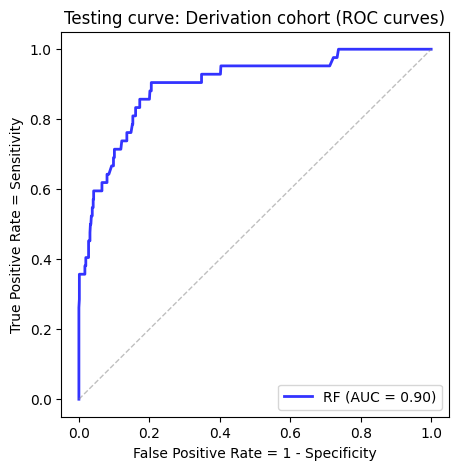

In [21]:
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probas_test[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Testing curve: Derivation cohort (ROC curves)')

# plot_Shapley(clf, X_test, columns, 'Derivation cohort', 25)

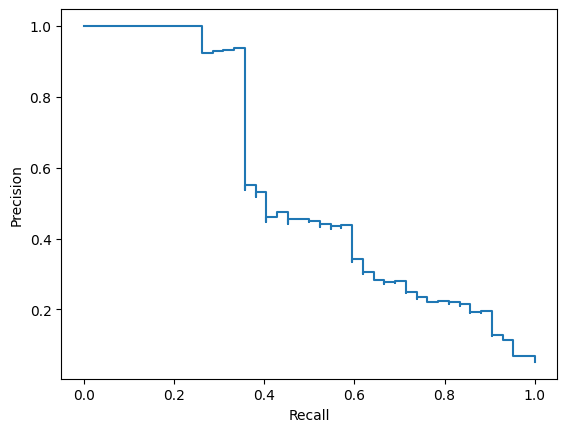

In [22]:
# Compute precision & recall
precision_test = average_precision_score(y_test, pred_probas_test[:,1])

plot_precision_recall(y_test, pred_probas_test[:,1])

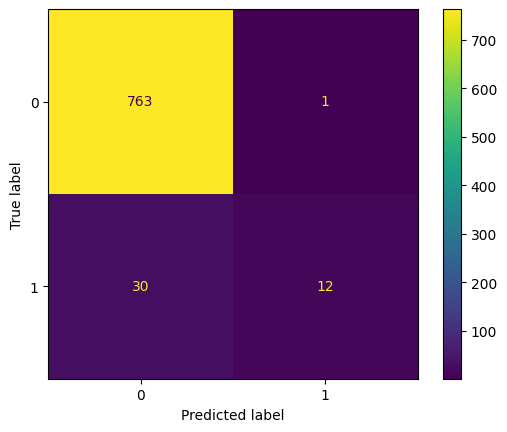

In [23]:
plot_confusion_matrix(y_test, clf.predict(X_test))

In [24]:
classes = list(map(str, clf.classes_.tolist()))
print(classification_report(y_test.tolist(), clf.predict(X_test).tolist(), target_names=classes))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       764
           1       0.92      0.29      0.44        42

    accuracy                           0.96       806
   macro avg       0.94      0.64      0.71       806
weighted avg       0.96      0.96      0.95       806



In [25]:
print("Precision: {:.2f}".format(round(precision_test, 2)))

Precision: 0.55


In [26]:
risk_groups_test.head()

,Low risk,Intermediate risk,High risk
Count (N),604,165,37


## Validation

via external public dataset

In [27]:
print("External Dataset")
pred_probas_val = clf.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

External Dataset


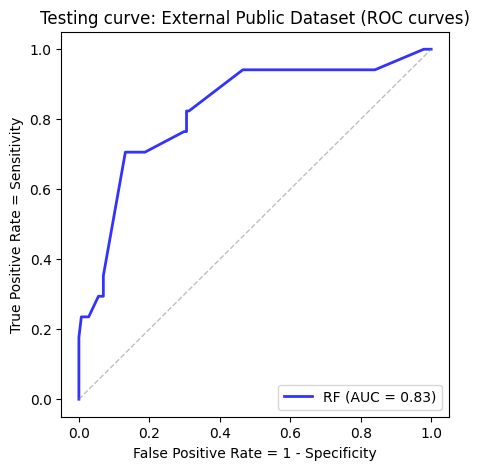

In [28]:
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_val, pred_probas_val[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Testing curve: External Public Dataset (ROC curves)')

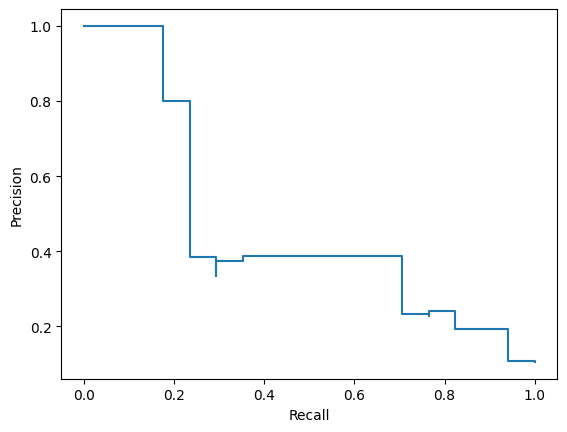

In [29]:
# Compute precision & recall
precision_val = average_precision_score(y_val, pred_probas_val[:,1])

plot_precision_recall(y_val, pred_probas_val[:,1])

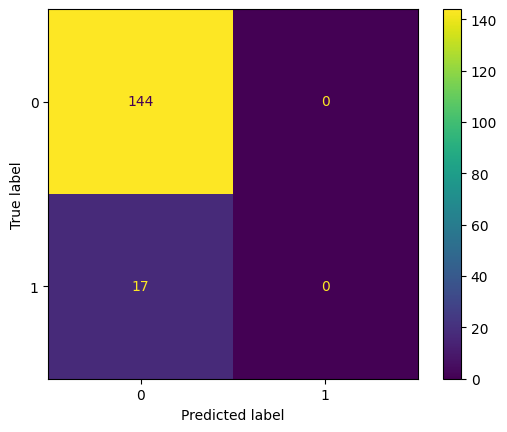

In [30]:
plot_confusion_matrix(y_val, clf.predict(X_val))

In [31]:
print(classification_report(y_val.tolist(), clf.predict(X_val).tolist(), target_names=classes))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       144
           1       0.00      0.00      0.00        17

    accuracy                           0.89       161
   macro avg       0.45      0.50      0.47       161
weighted avg       0.80      0.89      0.84       161



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [32]:
print("Precision: {:.2f}".format(round(precision_val, 2)))

Precision: 0.46


In [33]:
risk_groups_val.head()

,Low risk,Intermediate risk,High risk
Count (N),161,0,0
